## 0. An example of the data generation
### 0.1 Choose one slice from the original image series

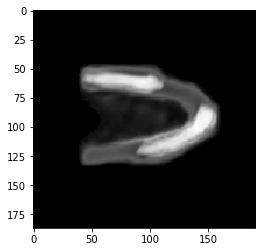

In [2]:
import pandas as pd
import math
import os
import numpy as np
import matplotlib.pyplot as plt
filename = 'Heart_191W_187H_600T_32bit_real2.raw' 
path = './'
os.chdir(path)
w = 191 #width
h = 187 #height
d = 600 #time length
n = 255 #max brightness 
data_test = np.empty((n, d, h, w), dtype='float32')
df_new = pd.DataFrame()
for i in range(0, n):
    data_test = np.memmap(filename, dtype=np.float32, shape = (d, h, w))
plt.imshow(data_test[580],  cmap=plt.get_cmap('gray')) 
image = data_test[82]
ground_truth = data_test[82] #25 dimmer, 200 bright 

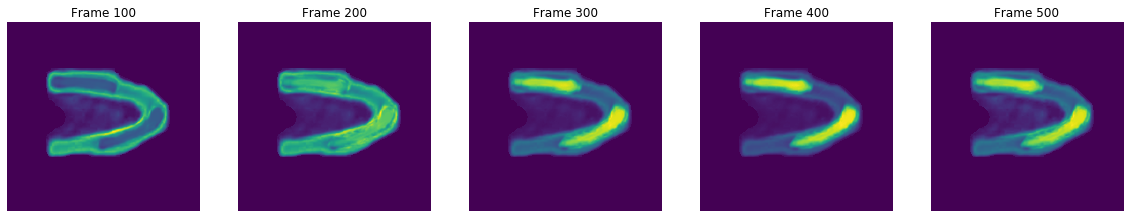

In [95]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(data_test[i*100+100])
    ax[i].set_title("Frame {}".format(i*100+100))
    ax[i].axis("off")
plt.show()

### 0.2 Set up the parameters which are used to get different heart motions

In [3]:
##########Parameters Rand ranges
im_t = 25 #number of frames 
ang = 1.5  #angle (degrees) (1-->1.5, floats) (-1 --> -1.5)
sc = .05  #scaling (scales up) :1.05 (.01 --> .06)
xt = 2  #x translation  (1-->4, floats) (-1 --> -4 floats)
yt = 2  #y translation  (1-->4, floats) (-1 --> -4 floats)
m_rate = [5, 5, 7]  #motion rate for R S T 
m_time = [3, 3, 4]  #motion time R S T

### 0.3 Functions used to simulate the heart motions (by OpenCV)

In [4]:
import numpy as np
import cv2 as cv
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]
def Affine_Transformation_RTS_openCV(image, imp, ang, tx, ty, sc):
####Rotation
    if imp == 'R':
        '''Function performs rotation using openCV, takes in ang as angle in degrees'''
        rows,cols = image.shape
        M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),-ang,1)
        out = cv.warpAffine(image,M,(cols,rows))#bilinear interpolation
        return out

######Scaling
    if imp == 'S':
        '''Function performs scaling using openCV, takes in scaling factor, crops image to original size'''
        height, width = image.shape[:2]
        new_width = math.floor(sc*width)
        new_height = math.floor(sc*height)
        scaled = cv.resize(image,(new_width, new_height), interpolation = cv.INTER_LINEAR) #bilinear interpolation
        out = crop_center(scaled, width, height)
        return out


#######Translation 
    if imp == 'T':
        rows,cols = image.shape
        '''Function performs translation using openCV, takes in x and y values'''
        M = np.float32([[1,0,tx],[0,1,ty]])
        out = cv.warpAffine(image,M,(cols,rows))
        return out

### 0.4 An example to use the previous functions

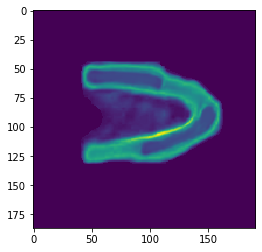

In [5]:
data_for_transformation = [] #run every new mouse 
for x in range(im_t):
    data_for_transformation.append(ground_truth)
plt.imshow(data_for_transformation[1])

transforms = 'RST'
ran = len(transforms)
for t in range(0,ran):
    #Rotation, Scaling, Translation 
    #print(transforms[t])
    #angle, translation x, translation y, scaling factor
    ang_count = 0  #angle 
    trx_count = 0  #x direction
    try_count = 0  #y direction 
    sc_count = 0   #scaling 
    for i in range(0,im_t):
        #print(trx_count)
        if ((i%m_rate[t] <= m_time[t])): #Every X seconds ossilation, will not do motion until m_rate 
            data_for_transformation[i] = Affine_Transformation_RTS_openCV(data_for_transformation[i],
                                                                          transforms[t],
                                                                          ang*ang_count,
                                                                          xt*trx_count,
                                                                          yt*try_count,
                                                                          1+(sc*sc_count))
            ang_count+=1
            trx_count+=1
            try_count+=1
            sc_count+=1
        else: 
            data_for_transformation[i] = data_for_transformation[i]
            ang_count = 0
            trx_count = 0
            try_count = 0
            sc_count = 0

### 0.5 Save the generated images to .raw (binary) file

In [36]:
trf = np.array(data_for_transformation)
trf.shape
[xs,ys,ts] = trf.shape
dft = trf.reshape(xs*ys*ts) 
dft.astype('float32').tofile('2_IEEE_Test_Heart_motion_191W_187H_200T_32bit_real.raw')

## 1. Generate different heart by scaling and shearing (with flipping)
### 1.1 Scaling and shearing functions

In [52]:
import cv2
from math import floor, ceil
from itertools import product

def scaling(input_img, scalex, scaley):
    # get the input rows and columns
    input_rows, input_cols = input_img.shape
    
    # create a template (zero array) to preserve the input size
    output_img = np.zeros((input_rows, input_cols))
    
    # resize the input image
    (resized_rows, resized_cols) = (ceil(input_rows*scalex), ceil(input_cols*scaley))
    # get the resized image by openCV method, use bilinear interpolation
    resized = cv2.resize(input_img, (resized_cols, resized_rows), interpolation=cv2.INTER_LINEAR)
    
    # compute the offset for the future cropping or padding
    offset1 = abs(input_rows - resized_rows)//2
    offset2 = abs(input_cols - resized_cols)//2
    
    # if scaling factor greater than 1: cropped the resized image
    if scalex >= 1 and scaley >= 1:
        output_img = resized[offset1:(offset1+input_rows), offset2:(offset2+input_cols)]
    # if scaling factor less than 1: padding the resized image
    elif scalex < 1 and scaley < 1:
        output_img[offset1:(offset1+resized_rows), offset2:(offset2+resized_cols)] = resized
    else:
        print("Error: Cannot do one dimension going up and one down.")
    
    return output_img


def shearing(image, shear_scale):
    rows, cols = image.shape
    
    # get shear matrix
    shear_scale_x, shear_scale_y = shear_scale
    shear_mat = np.array([[1, shear_scale_x/10, 0],
                          [shear_scale_y/10, 1, 0]]).astype("float32")
    # compute the shearing image
    shear_img = cv2.warpAffine(image, shear_mat, (rows,cols))
    
    return shear_img


### 1.2 Randomly select 15 images from the original image set (same shape but different pixel values)
5 for testing, 5 for validation, 5 for testing

In [7]:
import numpy as np

# function randomly select certain number of images from the sourse image set
def random_select(src_img_set, size):
    selected_img = []
    indices = np.random.choice(600, size, replace=False)
    print ("Selected indices:", indices)
    for i in indices:
        # cropped image to 128x128
        temp_img = src_img_set[i, :, 2:189]
        temp_img = temp_img[29:157, 29:157]
        
        # append to the list
        selected_img.append(temp_img)
    # done
    return selected_img

# selecte images from the original image set
all_img = random_select(data_test, 25)
# split them into train, validate, and test, they are 10:10:5
base_train = all_img[:10]
base_validate = all_img[10:20]
base_test = all_img[20:]

np.save("y_test", base_test)
np.save("y_validate", base_validate)

Selected indices: [461 537  20  27 143 421 311 546 386 200 283 407 478 117  97 202 293 328
 250 120  83 118 559 486 380]


### 1.3 Function to generate different hearts

In [80]:
from itertools import product

def different_heart(base_images):
    # store the different generated heart
    diff_heart_img = []
    # shearing factor, will divided by 10 in the shearing function
    shear_range = [0, 1, 3]
    # scaling factor, here only generate smaller images
    scalex = [0.6, 1]
    scaley = [0.6, 1]
    # generating hearts, also use flip to change the orientation of the image
    for shear_scale in product(shear_range, shear_range):
        for sx, sy in zip(scalex, scaley):
            for img in base_images:
                temp = shearing(scaling(img, sx, sy), shear_scale)

                diff_heart_img.append(temp)
                diff_heart_img.append(np.flipud(temp))
                diff_heart_img.append(np.fliplr(temp))
                diff_heart_img.append(np.flipud(np.fliplr(temp)))
    return diff_heart_img

diff_heart_img = different_heart(base_train)
print (len(diff_heart_img))

720


Text(0.5, 1.0, 'Scaling, shearing, and flipping horizontally')

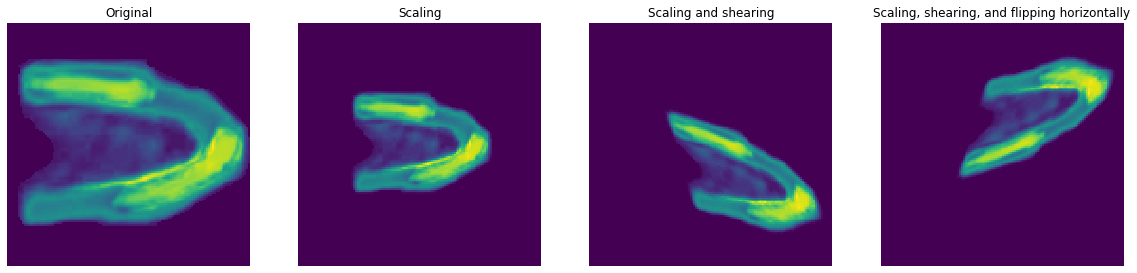

In [133]:
img = base_train[1]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.imshow(img)
ax1.axis("off")
ax1.set_title("Original")

ax2.imshow(scaling(img, 0.6, 0.6))
ax2.axis("off")
ax2.set_title("Scaling")

ax3.imshow(shearing(scaling(img, 0.6, 0.6), (3, 3)))
ax3.axis("off")
ax3.set_title("Scaling and shearing")

ax4.imshow(np.flipud(shearing(scaling(img, 0.6, 0.6), (3, 3))))
ax4.axis("off")
ax4.set_title("Scaling, shearing, and flipping horizontally")


## 2. Based on the generated hearts, create different heart motions for them

### 2.1 Functions to generate dynamic images (motions)

In [9]:
import numpy as np
import cv2 as cv
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]
def Affine_Transformation_RTS_openCV(image, imp, ang, tx, ty, sc):
####Rotation
    if imp == 'R':
        '''Function performs rotation using openCV, takes in ang as angle in degrees'''
        rows,cols = image.shape
        M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),-ang,1)
        out = cv.warpAffine(image,M,(cols,rows))#bilinear interpolation
        return out

######Scaling
    if imp == 'S':
        '''Function performs scaling using openCV, takes in scaling factor, crops image to original size'''
        height, width = image.shape[:2]
        new_width = math.floor(sc*width)
        new_height = math.floor(sc*height)
        scaled = cv.resize(image,(new_width, new_height), interpolation = cv.INTER_LINEAR) #bilinear interpolation
        out = crop_center(scaled, width, height)
        return out


#######Translation 
    if imp == 'T':
        rows,cols = image.shape
        '''Function performs translation using openCV, takes in x and y values'''
        M = np.float32([[1,0,tx],[0,1,ty]])
        out = cv.warpAffine(image,M,(cols,rows))
        return out

In [10]:
class heart_motion:
    def __init__(self, im_t, ang, sc, xt, yt, m_rate, m_time):
        self.im_t = im_t  #number of frames 
        self.ang = ang  #angle (degrees) (1-->1.5, floats) (-1 --> -1.5)
        self.sc = sc  #scaling (scales up) :1.05 (.01 --> .06)
        self.xt = xt  #x translation  (1-->4, floats) (-1 --> -4 floats)
        self.yt = yt  #y translation  (1-->4, floats) (-1 --> -4 floats)
        self.m_rate = m_rate  #motion rate for R S T 
        self.m_time = m_time  #motion time R S T
        
    def generate_motion(self, data_for_transformation):
        #One direction movement 
        transforms = 'RST'
        ran = len(transforms)
        for t in range(0,ran):
            #Rotation, Scaling, Translation 
            #print(transforms[t])
            #angle, translation x, translation y, scaling factor
            ang_count = 0  #angle 
            trx_count = 0  #x direction
            try_count = 0  #y direction 
            sc_count = 0   #scaling 
            temp = []
            for i in range(0,self.im_t):
                #print(trx_count)
                if i <= self.m_time[t]:
                    temp_img = Affine_Transformation_RTS_openCV(data_for_transformation[i], transforms[t],
                                                                self.ang*ang_count, self.xt*trx_count,
                                                                self.yt*try_count, 1+(self.sc*sc_count))
                    data_for_transformation[i] = temp_img
                    temp.append(temp_img)
                    ang_count+=1
                    trx_count+=1
                    try_count+=1
                    sc_count+=1

                elif i > self.m_time[t]:
                    temp_id = i % self.m_rate[t]
                    #print (temp_id, len(temp))
                    if temp_id < len(temp):
                        data_for_transformation[i] = temp[temp_id]
                        ang_count+=1
                        trx_count+=1
                        try_count+=1
                        sc_count+=1
                    else:
                        data_for_transformation[i] = data_for_transformation[i]
                        ang_count = 0
                        trx_count = 0
                        try_count = 0
                        sc_count = 0
        # done. Return the array
        return np.asarray(data_for_transformation)

### 2.2 One motion for test set

In [120]:
from skimage.transform import radon, iradon

# parameters for motion
im_t = 100  #number of frames 
ang = 1.5  #angle (degrees) (1-->1.5, floats) (-1 --> -1.5)
sc = .05  #scaling (scales up) :1.05 (.01 --> .06)
xt = 2  #x translation  (1-->4, floats) (-1 --> -4 floats)
yt = 2  #y translation  (1-->4, floats) (-1 --> -4 floats)
m_rate = [5, 5, 7]  #motion rate for R S T 
m_time = [3, 3, 4]  #motion time R S T

# create an object for heart motion generation
mheart = heart_motion(im_t, ang, sc, xt, yt, m_rate, m_time)

# base images for motions
x_test = []
for ground_truth in base_test:
    # use a certain image
    data_for_transformation = [] #run every new mouse 
    for x in range(im_t):
        data_for_transformation.append(ground_truth)
    
    # create motions
    x_test.append(mheart.generate_motion(data_for_transformation))
    
#plt.imshow(data_for_transformation[1])
theta = np.linspace(0., 180., 64, endpoint=True)
offset = -5
fbp_test = []
for k, imgs in enumerate(x_test):
    # get the average
    temp = np.zeros((128, 128))
    for i in range(20+offset):
        temp += imgs[i]
    temp = temp/(20+offset)
    # compute the sinogram of average
    sino = radon(temp, theta=theta)
    fbp_test.append(radon(temp, theta=theta, circle=False))
    x_test[k] = sino
    offset += 1
    blur_imgs.append(temp)

#np.save("fbp_test1", fbp_test)
#np.save("x_test1", x_test)
#np.save("y_test1", base_test)

### Another motion for validation set

In [119]:
import time
from skimage.transform import radon, iradon

# parameters for motion
im_t = 100  #number of frames 
ang = -1  #angle (degrees) (1-->1.5, floats) (-1 --> -1.5)
sc = .03  #scaling (scales up) :1.05 (.01 --> .06)
xt = -3 #x translation  (1-->4, floats) (-1 --> -4 floats)
yt = -3  #y translation  (1-->4, floats) (-1 --> -4 floats)
m_rate = [3, 3, 5]  #motion rate for R S T 
m_time = [2, 2, 4] #motion time R S T

# create an object for heart motion generation
mheart = heart_motion(im_t, ang, sc, xt, yt, m_rate, m_time)

# base images for motions
x_validate = []
for ground_truth in base_validate:
    # use a certain image
    data_for_transformation = [] #run every new mouse 
    for x in range(im_t):
        data_for_transformation.append(ground_truth)
    
    # create motions
    x_validate.append(mheart.generate_motion(data_for_transformation))
    
#plt.imshow(data_for_transformation[1])

theta = np.linspace(0., 180., 64, endpoint=True)
offset = 0
fbp_validate = []
for k, imgs in enumerate(x_validate):
    # get the average
    temp = np.zeros((128, 128))
    for i in range(20+offset):
        temp += imgs[i]
    temp = temp/(20+offset)
    # compute the sinogram of average
    sino = radon(temp, theta=theta)
    fbp_validate.append(radon(temp, theta=theta, circle=False))
    x_validate[k] = sino
    offset += 1
    blur_imgs.append(temp)

#np.save("fbp_validate1", fbp_validate)
#np.save("x_validate1", x_validate)
#np.save("y_validate1", base_validate)

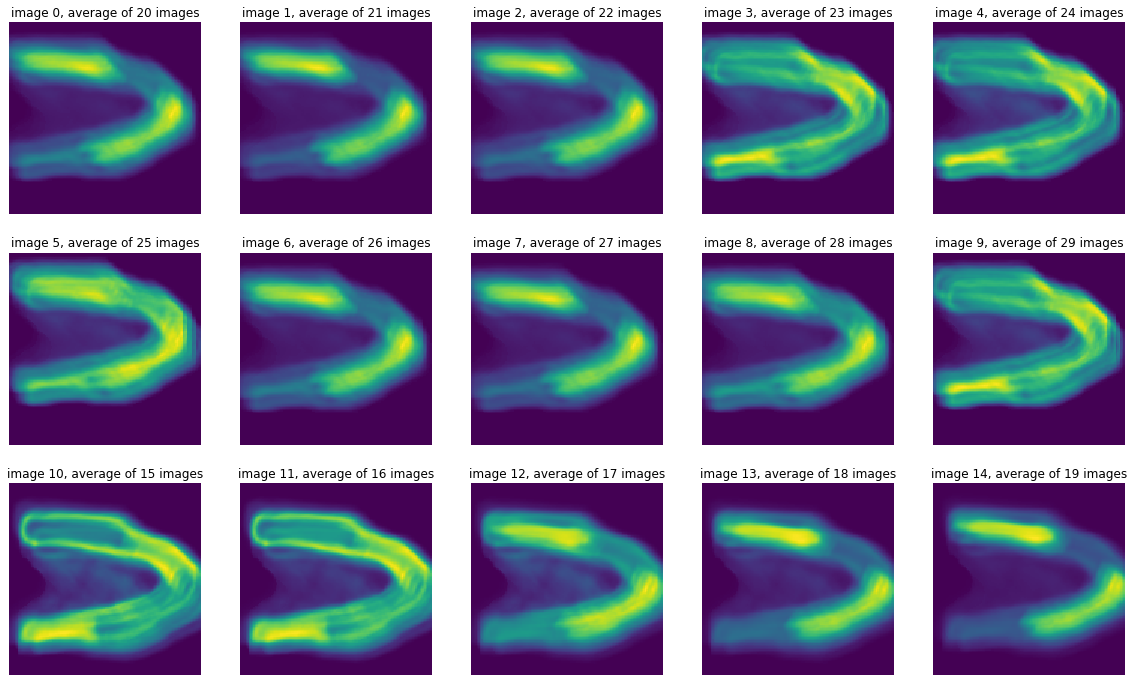

In [122]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(blur_imgs[i*5+j])
        ax[i, j].axis("off")
        ax[i, j].set_title("image {}, average of {} images".format(i*5+j, c[i*5+j]))

### More motions for training set

In [76]:
heart_motions = []
for sc in [0.03, 0.06]:
    for xt in [-3.5, -1.5, 1.5, 3.5]:
        for yt in [-3.5, -1.5, 1.5, 3.5]:
            a = [[6, 6, 4], [4, 4, 6]]
            b = [[5, 5, 7], [3, 3, 6]]
            for m_rate, m_time in zip(a, b):
                heart_motions.append(heart_motion(im_t, ang, sc, xt, yt, m_rate, m_time))


In [81]:
x_train = []
y_train = []
for ground_truth in diff_heart_img:
    # use a certain image
    data_for_transformation = [] #run every new mouse 
    for x in range(im_t):
        data_for_transformation.append(ground_truth)
    
    for motion in heart_motions:
        # create motions
        imgs = motion.generate_motion(data_for_transformation)
        
        # compute the averate of motion images
        offset = np.random.randint(10) - 5
        # get the average
        temp = np.zeros((128, 128))
        for i in range(20+offset):
            temp += imgs[i]
        temp = temp/(20+offset)
        # compute the sinogram of average
        sino = radon(temp, theta=theta)
        x_train.append(sino)
        y_train.append(ground_truth)
np.save("x_train", x_train)
np.save("y_train", y_train)

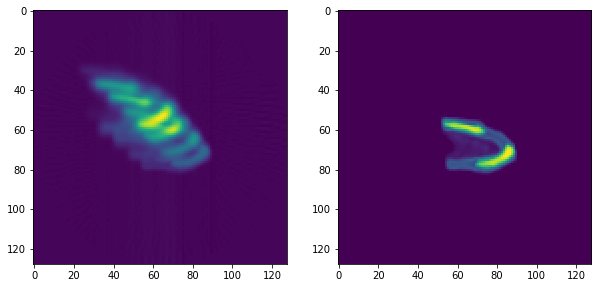

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
iii = 1
sino = x_train[iii]
img = y_train[iii]
fbp = iradon(sino, theta=theta)
proj = radon(img, theta=theta)

ax[0].imshow(fbp)
ax[1].imshow(img)
plt.show()

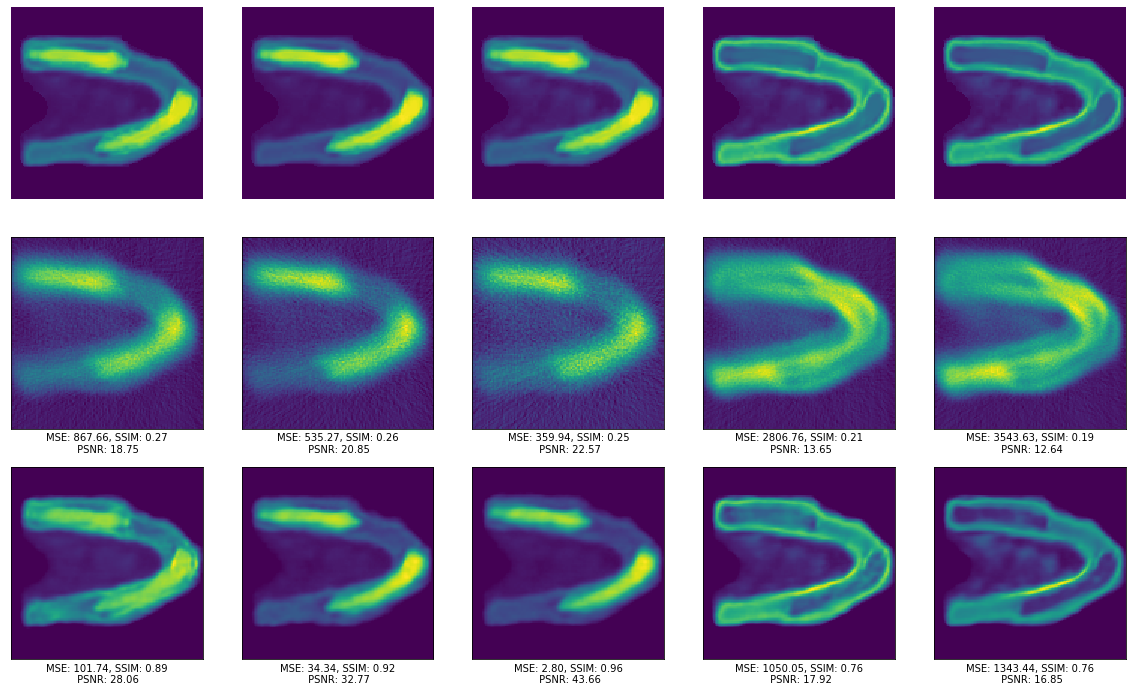

In [147]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from math import log10, sqrt
from skimage.transform import iradon
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

def compare(original, prediction):
    # compute mse, ssim, and psnr
    #mse_val = np.square(original - prediction).mean(axis=None)
    mse_val = mean_squared_error(original, prediction)
    nrmse = sqrt(mse_val) / (original.mean())
    ssim_val = ssim(original, prediction, data_range=255)
    max_pixel = 255
    psnr_val = 20 * log10(max_pixel / sqrt(mse_val)) 
    
    return mse_val, nrmse, ssim_val, psnr_val

# linear normalization
def normalization(arr):
    arr_norm = np.zeros(arr.shape)
    arr_norm = cv2.normalize(arr, arr_norm, 0, 255, cv2.NORM_MINMAX)
    return arr_norm

#x_test = add_noise(x_test, 5, 2)
y_test1 = np.load("./data/y_validate1.npy")
y_test2 = np.load("./data/y_test1.npy")
y_test = np.concatenate((y_test1, y_test2))

y_pred = np.load("./data/y_pred.npy")

fbp_test = np.load("./data/y_fbp.npy")
fbp_test = normalization(fbp_test)

# normalized
y_test = normalization(y_test)
y_test = y_test[..., np.newaxis]

theta = np.linspace(0., 180., 64, endpoint=True)
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    ax[0, i].imshow(y_test[i, :, :, 0])
    ax[0, i].axis("off")
    
    #fbp = iradon(fbp_test[i], theta)
    fbp = fbp_test[i]
    ax[1, i].imshow(fbp)
    mse_val1, nrmse1, ssim_val1, psnr_val1 = compare(y_test[i, :, :, 0], fbp)
    label = "MSE: {:.02f}, SSIM: {:.02f}\n PSNR: {:.02f}".format(mse_val1, ssim_val1, psnr_val1)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_xlabel(label)
    #ax[1, i].axis("off")
    
    ax[2, i].imshow(y_pred[i, :, :, 0])
    mse_val2, nrmse2, ssim_val2, psnr_val2 = compare(y_test[i, :, :, 0], y_pred[i, :, :, 0])
    label = "MSE: {:.02f}, SSIM: {:.02f}\n PSNR: {:.02f}".format(mse_val2, ssim_val2, psnr_val2)
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])
    ax[2, i].set_xlabel(label)


In [153]:
a = np.load("./data/fbp_test1.npy")
b = np.load("./data/fbp_validate1.npy")
c = np.concatenate((b, a))
fbp_list = []
start = time.time()
for sino in c:
    temp = iradon(sino, theta=theta)
    fbp_list.append(temp[27:155, 27:155])
end = time.time()
print (end-start, "seconds")

0.45084214210510254 seconds


In [109]:
import pandas as pd
from IPython.display import display
from itertools import chain
from math import log10, sqrt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# linear normalization
def normalization(arr):
    arr_norm = np.zeros(arr.shape)
    arr_norm = cv2.normalize(arr, arr_norm, 0, 255, cv2.NORM_MINMAX)
    return arr_norm

y_test1 = np.load("./data/y_validate1.npy")
y_test2 = np.load("./data/y_test1.npy")
y_test = np.concatenate((y_test1, y_test2))
y_test = normalization(y_test)

y_pred = np.load("./data/y_pred.npy")
y_fbp = np.load("./data/y_fbp.npy")
y_fbp = normalization(y_fbp)

text1 = ["image {}".format(i) for i in range(15)]
text2 = ["MSE", "SSIM", "PSNR"]
text3 = ["FBP", "CED"]

temp = [[i]*2 for i in text2]
arr1 = list(chain.from_iterable(temp))

temp = [text3]*3
arr2 = list(chain.from_iterable(temp))

arr = [arr1, arr2]

tup = list(zip(*arr))
indice = pd.MultiIndex.from_tuples(tup, names=["Measurement", "Recon Method"])

data = np.zeros((15, 6))
for k in range(15):
    data[k, 0] = mean_squared_error(y_test[k, ...], y_fbp[k, ...])
    data[k, 1] = mean_squared_error(y_test[k, ...], y_pred[k, ..., 0])

for k in range(15):
    data[k, 2] = ssim(y_test[k, ...], y_fbp[k, ...], data_range=255)
    data[k, 3] = ssim(y_test[k, ...], y_pred[k, ..., 0], data_range=255)

for k in range(15):
    temp = mean_squared_error(y_test[k, ...], y_fbp[k, ...])
    data[k, 4] = 20 * log10(255 / sqrt(temp)) 
    temp = mean_squared_error(y_test[k, ...], y_pred[k, ..., 0])
    data[k, 5] = 20 * log10(255 / sqrt(temp)) 

row_mean = np.zeros((1, 6))
row_std = np.zeros((1, 6))
for i in range(6):
    row_mean[:, i] = np.average(data[:, i])
    row_std[:, i] = np.std(data[:, i])
data = np.concatenate((data, row_mean, row_std))
text1 = text1 + ["mean", "std"]
df = pd.DataFrame(data, index=text1, columns=indice)
display(df)

Measurement           MSE                   SSIM                 PSNR  \
Recon Method          FBP          CED       FBP       CED        FBP   
image 0        867.661961   101.735718  0.273729  0.894444  18.747298   
image 1        535.272342    34.341312  0.264899  0.922275  20.845056   
image 2        359.944186     2.801375  0.254331  0.963916  22.568452   
image 3       2806.760184  1050.047974  0.205136  0.755739  13.648751   
image 4       3543.626473  1343.436768  0.190422  0.763849  12.636324   
image 5       1356.798138   302.883606  0.242431  0.752950  16.805651   
image 6        827.938307   102.084991  0.278970  0.891925  18.950824   
image 7        746.476515    84.569305  0.279934  0.896287  19.400642   
image 8        953.315276   111.812096  0.280211  0.887881  18.338438   
image 9       2795.053390   857.652954  0.189616  0.819846  13.666903   
image 10      3573.719007  2373.217285  0.282780  0.475297  12.599600   
image 11      2693.444234  1497.405884  0.280421  0.510685  13.827724   
image 12       289.903909     2.286632  0.189540  0.953643  23.508263   
image 13       361.178313     7.396820  0.248931  0.926704  22.553587   
image 14       621.542258    86.682831  0.281130  0.790970  20.196097   
mean          1488.842300   530.557037  0.249499  0.813761  17.886241   
std           1177.171635   704.080475  0.035907  0.143316   3.675918   

Measurement              
Recon Method        CED  
image 0       28.056069  
image 1       32.772635  
image 2       43.657091  
image 3       17.918712  
image 4       16.848631  
image 5       23.318046  
image 6       28.041185  
image 7       28.858676  
image 8       27.645916  
image 9       18.797688  
image 10      14.377429  
image 11      16.377408  
image 12      44.538842  
image 13      39.440353  
image 14      28.751473  
mean          27.293343  
std            9.379151